📚 Import Libraries

In [ ]:
import numpy as np
import tensorflow as tf

from IPython.display import Image, display
from tensorflow.keras import utils
from tensorflow.keras import optimizers
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model

⚙️ Configuration & Hyperparameters

In [ ]:
# Define file paths
base_image_path = "content_images/elephant.jpg"  # 🐘 Content image (base)
style_image_path = "style_images/forest.jpg"  # 🌲 Style reference image
result_prefix = "elephant_forest"  # Output file prefix

# ⚖️ Weights of the different loss components
content_weight = 2.5e-8
style_weight = 1e-6
total_variation_weight = 1e-6

# 🖼️ Dimensions of the output image
width, height = utils.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

👀 Preview Images

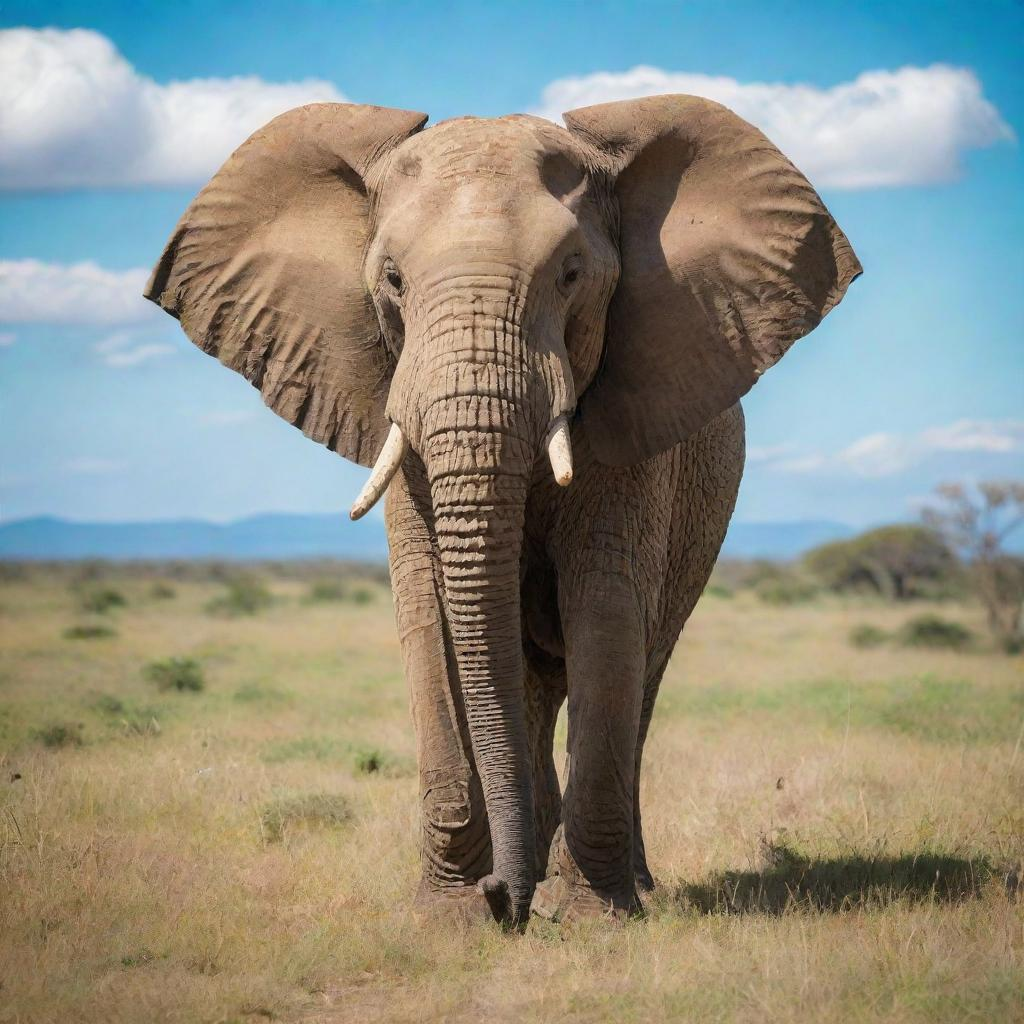

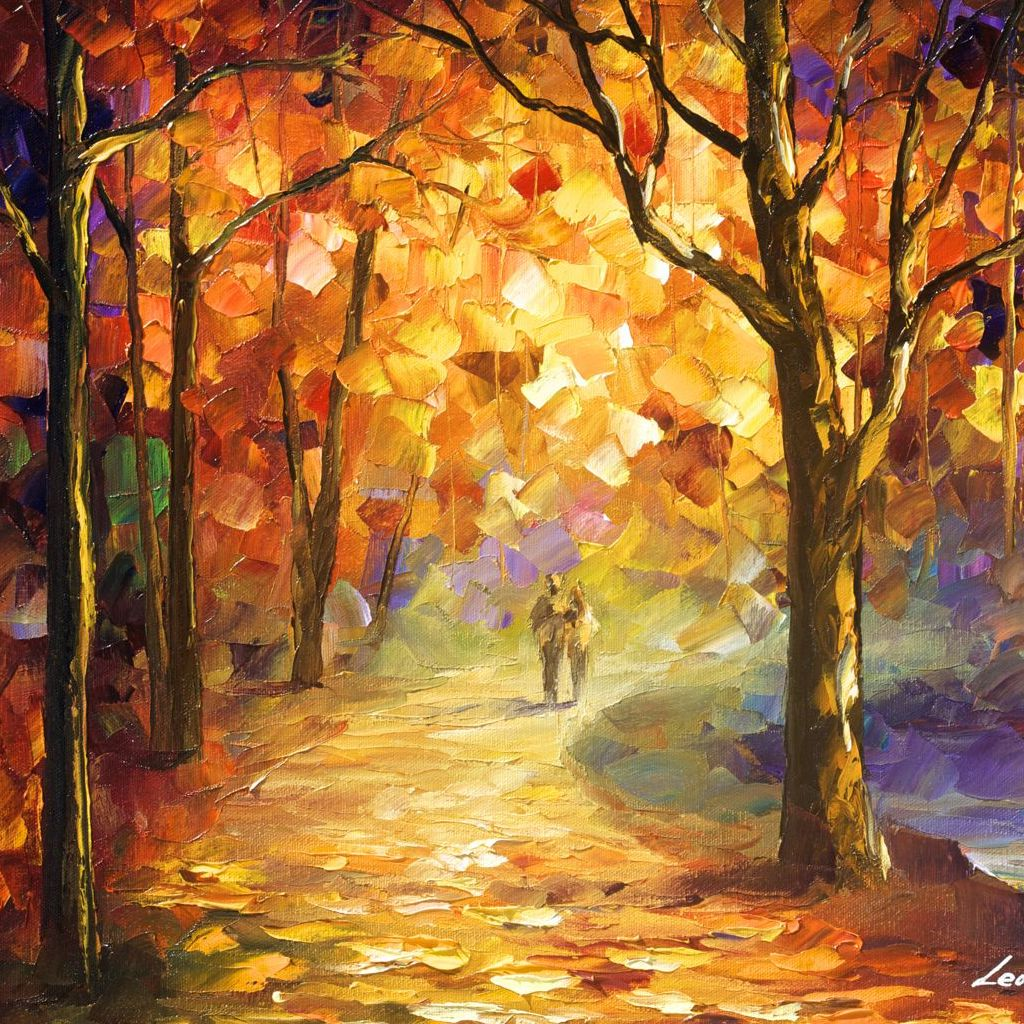

In [ ]:
# Show the base (content) image
display(Image(base_image_path, width=img_ncols, height=img_nrows))

# Show the style image
display(Image(style_image_path, width=img_ncols, height=img_nrows))

🛠️ Image Preprocessing / Deprocessing Functions

In [ ]:
def preprocess_image(image_path):
    """Convert image into a tensor suitable for VGG19 input."""
    img = utils.load_img(image_path, target_size=(img_nrows, img_ncols))
    img = utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(
        img
    )  # Apply VGG19 preprocessing (BGR, mean-subtraction)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    """Convert processed tensor back to a valid image."""
    x = x.reshape((img_nrows, img_ncols, 3))
    # Revert mean pixel subtraction
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # Convert from BGR back to RGB
    x = x[:, :, ::-1]
    # Clip to [0, 255] range
    x = np.clip(x, 0, 255).astype("uint8")
    return x

📐 Define Loss Functions

In [ ]:
def gram_matrix(x):
    """Compute Gram matrix (captures style by correlations between features)."""
    x = tf.transpose(x, (2, 0, 1))  # Reorder dimensions: channels first
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, combination):
    """Style loss: how close the combination image is to the style reference."""
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(C - S)) / (4.0 * (channels**2) * (size**2))


def content_loss(base, combination):
    """Content loss: ensures combination image preserves content structure."""
    return tf.reduce_sum(tf.square(combination - base))


def total_variation_loss(x):
    """Regularization: encourages spatial smoothness in the output image."""
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

🧠 Create Feature Extraction Model

In [ ]:
# Load pre-trained VGG19 (ImageNet weights, no classifier top layers)
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Extract intermediate outputs from all layers
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Build a feature extractor model
feauture_extractor = Model(inputs=model.inputs, outputs=outputs_dict)

🔗 Define Total Loss Function

In [ ]:
# 🎨 Layers to use for style representation
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# 🐘 Layer to use for content representation
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_image):
    """Compute the total loss (content + style + variation)."""
    # Concatenate inputs into one batch
    input_tensor = tf.concat([base_image, style_image, combination_image], axis=0)
    features = feauture_extractor(input_tensor)

    # Initialize loss
    loss = tf.zeros(shape=())

    # 🐘 Content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features, combination_features)

    # 🎨 Style loss (averaged over multiple layers)
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_image_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_image_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # ✨ Total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

⚡ Compute Loss & Gradients

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_image):
    """Compute both loss and gradients (for optimization)."""
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

🔁 Training Loop

In [ ]:
# Exponential learning rate decay
optimizer = optimizers.SGD(
    optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

# Preprocess input images
base_image = preprocess_image(base_image_path)
style_image = preprocess_image(style_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

# Training parameters
epochs = 4000
for i in range(1, epochs + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_image)
    optimizer.apply_gradients([(grads, combination_image)])

    # Print progress every 100 iterations
    if i % 100 == 0:
        print(f"Epoch {i}: loss={loss:.2f}")

        # Save intermediate results every 500 iterations
        if i % 500 == 0:
            img = deprocess_image(combination_image.numpy())
            fname = f"output_images/{result_prefix}_at_epoch_{i}.png"
            utils.save_img(fname, img)

Epoch 100: loss=4416.37
Epoch 200: loss=3334.71
Epoch 300: loss=2952.55
Epoch 400: loss=2740.75
Epoch 500: loss=2597.94
Epoch 600: loss=2487.65
Epoch 700: loss=2400.25
Epoch 800: loss=2328.03
Epoch 900: loss=2267.36
Epoch 1000: loss=2215.08
Epoch 1100: loss=2169.69
Epoch 1200: loss=2130.01
Epoch 1300: loss=2094.95
Epoch 1400: loss=2063.66
Epoch 1500: loss=2035.49
Epoch 1600: loss=2010.09
Epoch 1700: loss=1987.02
Epoch 1800: loss=1965.98
Epoch 1900: loss=1946.73
Epoch 2000: loss=1929.00
Epoch 2100: loss=1912.65
Epoch 2200: loss=1897.50
Epoch 2300: loss=1883.44
Epoch 2400: loss=1870.35
Epoch 2500: loss=1858.18
Epoch 2600: loss=1846.84
Epoch 2700: loss=1836.28
Epoch 2800: loss=1826.40
Epoch 2900: loss=1817.15
Epoch 3000: loss=1808.48
Epoch 3100: loss=1800.36
Epoch 3200: loss=1792.72
Epoch 3300: loss=1785.53
Epoch 3400: loss=1778.75
Epoch 3500: loss=1772.36
Epoch 3600: loss=1766.33
Epoch 3700: loss=1760.63
Epoch 3800: loss=1755.25
Epoch 3900: loss=1750.16
Epoch 4000: loss=1745.35


🖼️ Display Final Output Image

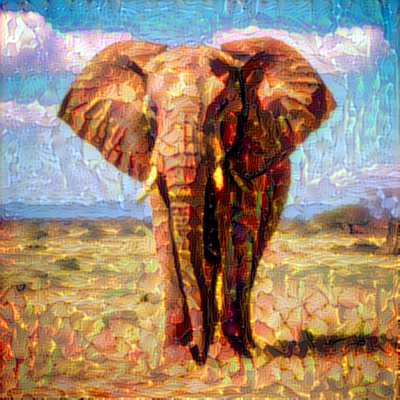

In [ ]:
display(Image(f"output_images/{result_prefix}_at_epoch_{epochs}.png"))